## The goal is to train a emotional state classifier.
## Facial expression data is modified from https://www.kaggle.com/c/3364.
## Link to download data and models: https://drive.google.com/drive/folders/1jO-1vWnHj5yLd3P39Zu1o00GLP_nrdtc?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import collections
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.0
2.4.0


In [3]:
data_path = 'project_data.csv'
image_size=(48,48)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces, emotions = load_data(data_path)

## Sample Face

Emotion Labels [1 0 0 0 0 0]


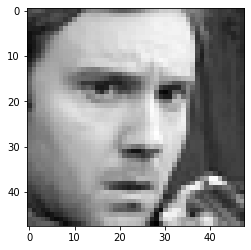

In [4]:
ind = 0
f = faces[ind, :,:,0]
print('Emotion Labels', emotions[ind,:])
plt.imshow(f, cmap='gray')

C:\Users\monol\.conda\envs\tf\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


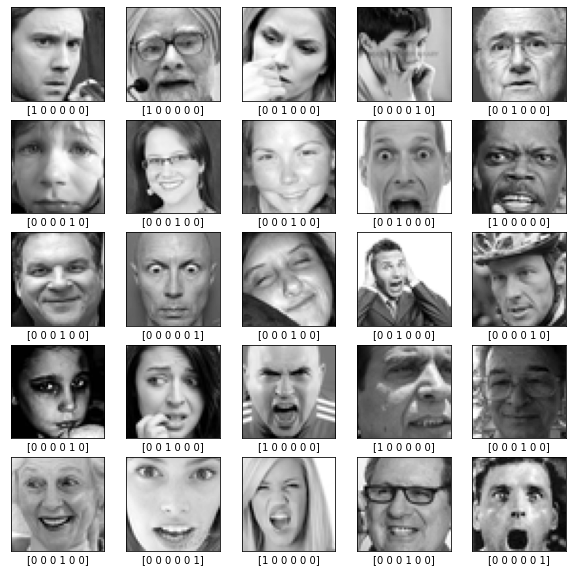

In [5]:
plt.figure(figsize=(10,10))

# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces[i, :, :, 0], cmap='gray')
    plt.xlabel(emotions[i,:])

## Data Augmentation

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(faces,emotions, test_size=0.2)

In [9]:
train_batchsize = 128
validation_batchsize = 128

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(
    x = x_train,
    y = y_train,
    shuffle = True,
    batch_size=train_batchsize,
    subset='training') # set as training data

validation_generator = datagen.flow(
    x = x_train,
    y = y_train,
    batch_size=validation_batchsize,
    subset='validation') # set as validation data

## Set Callbacks

In [7]:
# Callbacks
patience = 20
early_stoping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    mode="max",
    restore_best_weights=True,
    verbose=1,
    patience=patience
)

filepath = "Test_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    mode='max',
    monitor='val_accuracy', 
    verbose=2, 
    save_best_only=True
    )

lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=4, 
    verbose=1,
    factor=0.5, 
    min_lr=0.00001
)

callbacks_list = [early_stoping,checkpoint,lr_plateau]

## CNN Model

In [12]:
model_CNN = models.Sequential([
    layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(256, (5, 5),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="same"),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Dense(6, activation='softmax')
])
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        128       
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 256)      

## Compile the model

In [15]:
model_CNN.compile(
    optimizer = optimizers.Adam(lr=.00025), 
    loss = 'categorical_crossentropy', 
    metrics=['accuracy']
)

## Model Traning

In [17]:
epochs = 100

history_1 = model_CNN.fit(
      train_generator,
      steps_per_epoch=train_generator.n/train_generator.batch_size ,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.n/validation_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list
)

==============] - 18s 155ms/step - loss: 1.6515 - accuracy: 0.3228 - val_loss: 1.5321 - val_accuracy: 0.3604

Epoch 00009: val_accuracy improved from 0.35852 to 0.36036, saving model to Test_model.h5
Epoch 10/100
118/118 [==============================] - 17s 142ms/step - loss: 1.6097 - accuracy: 0.3385 - val_loss: 1.5197 - val_accuracy: 0.3635

Epoch 00010: val_accuracy improved from 0.36036 to 0.36352, saving model to Test_model.h5
Epoch 11/100
118/118 [==============================] - 17s 142ms/step - loss: 1.6061 - accuracy: 0.3429 - val_loss: 1.4886 - val_accuracy: 0.3827

Epoch 00011: val_accuracy improved from 0.36352 to 0.38273, saving model to Test_model.h5
Epoch 12/100
118/118 [==============================] - 17s 142ms/step - loss: 1.5813 - accuracy: 0.3606 - val_loss: 1.4901 - val_accuracy: 0.3933

Epoch 00012: val_accuracy improved from 0.38273 to 0.39326, saving model to Test_model.h5
Epoch 13/100
118/118 [==============================] - 17s 142ms/step - loss: 1.5498 

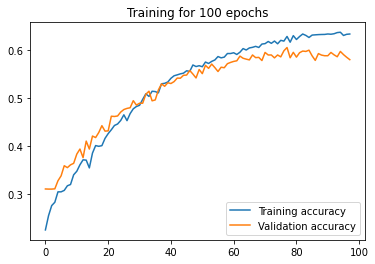

In [18]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [19]:
epochs = 100

history_2 = model_CNN.fit(
      train_generator,
      steps_per_epoch=train_generator.n/train_generator.batch_size ,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.n/validation_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list
)

Epoch 1/100
118/118 [==============================] - 21s 173ms/step - loss: 0.9592 - accuracy: 0.6212 - val_loss: 1.0307 - val_accuracy: 0.5938

Epoch 00001: val_accuracy did not improve from 0.60490
Epoch 2/100
118/118 [==============================] - 20s 168ms/step - loss: 0.9649 - accuracy: 0.6265 - val_loss: 1.0357 - val_accuracy: 0.5946

Epoch 00002: val_accuracy did not improve from 0.60490
Epoch 3/100
118/118 [==============================] - 20s 165ms/step - loss: 0.9586 - accuracy: 0.6248 - val_loss: 1.0133 - val_accuracy: 0.6033

Epoch 00003: val_accuracy did not improve from 0.60490
Epoch 4/100
118/118 [==============================] - 20s 172ms/step - loss: 0.9485 - accuracy: 0.6276 - val_loss: 1.0452 - val_accuracy: 0.5902

Epoch 00004: val_accuracy did not improve from 0.60490
Epoch 5/100
118/118 [==============================] - 20s 165ms/step - loss: 0.9508 - accuracy: 0.6238 - val_loss: 1.0355 - val_accuracy: 0.5988

Epoch 00005: val_accuracy did not improve fro

In [22]:
# We divide by 255. to rescale data
test_loss, test_acc = model_CNN.evaluate(x_test/255.,y_test)
print("test accuracy:",test_acc)

149/149 [==============================] - 2s 12ms/step - loss: 0.9095 - accuracy: 0.6422
test accuracy: 0.6422404646873474


## Seems like we hit boteleneck lets see if making data more balanced can help 

In [8]:
data_path = 'project_data.csv'
image_size=(48, 48)

# Helper functions
def load_data(data_path):
    data_set = pd.read_csv(data_path)
    x = data_set['pixels']
    y = data_set['emotion']
    return x, y

def oversampling(x, y):
    x = x.values.reshape(-1, 1)
    print('before oversampling:', collections.Counter(y))
    
    oversample = RandomOverSampler(sampling_strategy='auto')
    x_over, y_over = oversample.fit_resample(x.reshape(-1, 1), y)
    a = np.array(y_over)
    print('after oversampling:', collections.Counter(a))
    
    y_over = pd.Series(y_over)
    y_over= y_over.values.reshape(len(y_over),1)

    return x_over, y_over

def preprocessing(pixels):
    a = []
    
    for i in range(len(pixels)):
            image_string = (pixels)[i].split(' ') 
            image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48,1)
            a.append(image_data)

    return a

def reshape(x):
    print('before:', x.shape)
    a= []
    x = pd.Series(x.flatten())
    a = preprocessing(x)
    x = np.array(a)
    print('after:', x.shape)
    return x

In [9]:
#Load data
x, y = load_data(data_path)

#Oversampling so each class has same number of examples
x_over, y_over = oversampling(x, y)

#train test split
x_train,x_test,y_train,y_test = train_test_split(x_over,y_over, test_size=0.2)

#Reshape to fit in as input to model
x_train = reshape(x_train)

before oversampling: Counter({3: 7215, 4: 4830, 2: 4097, 0: 3995, 5: 3171, 1: 436})
after oversampling: Counter({0: 7215, 2: 7215, 4: 7215, 3: 7215, 5: 7215, 1: 7215})
before: (34632, 1)
after: (34632, 48, 48, 1)


## Now data in each class flow evenly, lets go through similar routine as before

In [10]:
model_CNN_2 = models.Sequential([
    layers.Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(256, (5, 5),padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2),padding="same"),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    layers.Dense(6, activation='softmax')
])
model_CNN_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        128       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 256)       8

In [14]:
model_CNN_2.compile(
    optimizer = optimizers.Adam(lr=.00025), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [15]:
epochs = 100
history_3 = model_CNN_2.fit(
      x_train,
      y_train,
      batch_size=64,
      validation_split=0.25,      
      epochs=epochs,      
      verbose=1,
      callbacks=callbacks_list
)

Epoch 1/100
406/406 [==============================] - 45s 98ms/step - loss: 2.0461 - accuracy: 0.2716 - val_loss: 1.4852 - val_accuracy: 0.4160

Epoch 00001: val_accuracy improved from -inf to 0.41603, saving model to Test_model.h5
Epoch 2/100
406/406 [==============================] - 37s 91ms/step - loss: 1.5465 - accuracy: 0.4197 - val_loss: 1.2091 - val_accuracy: 0.5320

Epoch 00002: val_accuracy improved from 0.41603 to 0.53199, saving model to Test_model.h5
Epoch 3/100
406/406 [==============================] - 31s 76ms/step - loss: 1.2304 - accuracy: 0.5276 - val_loss: 1.0462 - val_accuracy: 0.5933

Epoch 00003: val_accuracy improved from 0.53199 to 0.59332, saving model to Test_model.h5
Epoch 4/100
406/406 [==============================] - 35s 86ms/step - loss: 1.0754 - accuracy: 0.5882 - val_loss: 0.9991 - val_accuracy: 0.6183

Epoch 00004: val_accuracy improved from 0.59332 to 0.61827, saving model to Test_model.h5
Epoch 5/100
406/406 [==============================] - 31s 

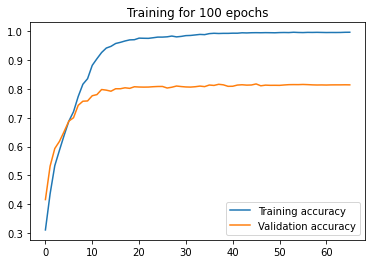

In [16]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [20]:
## Testing
test_loss, test_acc = model_CNN_2.evaluate(x_test, y_test) 
print('Test accuracy:', test_acc)

271/271 [==============================] - 4s 11ms/step - loss: 1.1440 - accuracy: 0.8061
Test accuracy: 0.8060753345489502


## The top solution on Kaggle is 70% but with one more emotion class, here we have modified data, but still results are promising 80% - accuracy

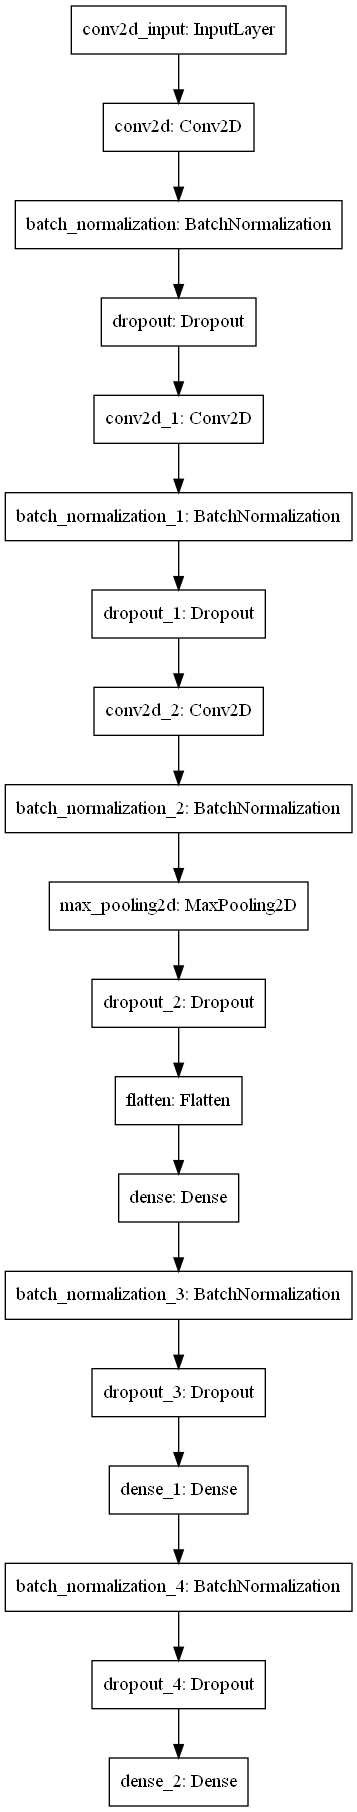

In [21]:
tf.keras.utils.plot_model(
    model_CNN_2, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)